In [1]:
import calib
from calib import detect_board, board_points
import glob, os
import cv2
from i308_utils import imshow, show_images
import pickle
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import json
from pathlib import Path
from disparity.method_cre_stereo import CREStereo
from disparity.method_opencv_bm import StereoBM, StereoSGBM
from disparity.methods import Calibration, InputPair, Config
from aux import export_ply_grayscale, draw_geometries
import aruco


# Calibración estéreo

In [2]:
checkerboard = (10, 7)
square_size_mm = 24.2

# creamos los puntos del mundo del objeto checkerboard
checkerboard_world_points_mm = board_points(checkerboard) * square_size_mm

directory = os.path.join("datasets", "buddha_board", "calib")
left_files_pattern = "*left*.jpg"
right_files_pattern = "*right*.jpg"

def numeric_sort(file_name):
    return int(file_name.split("_")[-1].split(".")[0])

left_file_names = sorted(
    glob.glob(
        os.path.join(directory, left_files_pattern)
    ),
    key=numeric_sort
)

right_file_names = sorted(
    glob.glob(
        os.path.join(directory, right_files_pattern)
    ),
    key=numeric_sort
)

num_left = len(left_file_names)
num_right = len(right_file_names)

if  num_left != num_right:
    raise Exception(f"the number of files (left {num_left} / right{num_right}) doesn't match")

In [3]:
image_size = None
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)

world_points = []
left_images = []
right_images = []
left_images_points = []
right_images_points = []

for left_file_name, right_file_name in zip(
    left_file_names, right_file_names
):
    # read left and right images
    left_image = cv2.imread(left_file_name, cv2.IMREAD_GRAYSCALE)
    right_image = cv2.imread(right_file_name, cv2.IMREAD_GRAYSCALE)

    # get the images sizes
    left_size = (left_image.shape[1], left_image.shape[0])
    right_size = (right_image.shape[1], right_image.shape[0])

    # checks that images sizes match
    if left_size != right_size:
        raise Exception(f"left and right images sizes differ: left {left_size} / right {right_size}")
        
    if image_size is None:
        # remembers the images size
        image_size = left_size
    else:
        if image_size != left_size:
            raise Exception(f"there are images with different sizes: {image_size} vs {left_size}")

    # finds the checkerboard in each image
    left_found, left_corners = cv2.findChessboardCorners(left_image, checkerboard)
    right_found, right_corners = cv2.findChessboardCorners(right_image, checkerboard)

    if not left_found or not right_found:
        print("warning, checkerboard was not found")
        continue

    # checkerboard was found in both images.

    # let's improve the found corners
    corners_left = cv2.cornerSubPix(left_image, left_corners, (7, 7), (-1,-1), criteria)
    corners_right = cv2.cornerSubPix(right_image, right_corners, (7, 7), (-1,-1), criteria)

    # acumulo las imagenes
    left_images.append(left_image)
    right_images.append(right_image)

    # acumulo los corners detectados
    left_images_points.append(left_corners)
    right_images_points.append(right_corners)

    # acumulo los puntos del mundo
    world_points.append(checkerboard_world_points_mm)

In [4]:
err, left_K, left_dist, right_K, right_dist, R, T, E, F = cv2.stereoCalibrate(
    world_points, 
    left_images_points, 
    right_images_points, 
    None, 
    None, 
    None, 
    None, 
    image_size, 
    flags=0
)

# serializamos los resultados en un pickle

calibration_results = {
    'left_K': left_K,
    'left_dist': left_dist,
    'right_K': right_K,
    'right_dist': right_dist,
    'R': R,
    'T': T,
    'E': E,
    'F': F,
    'image_size': image_size,
}

calibration_file = os.path.join("datasets", "buddha_board", "stereo_calibration.pkl")
with open(calibration_file, "wb") as f:
    f.write(pickle.dumps(calibration_results))

# Rectificación Estéreo

In [5]:
# realicemos la rectificación estéreo:
R1, R2, P1, P2, Q, validRoi1, validRoi2 = cv2.stereoRectify(
    left_K, left_dist, right_K, right_dist, image_size, R, T, alpha=0
)

# calculemos los mapas de des-distorsión-rectificación:
left_map_x, left_map_y = cv2.initUndistortRectifyMap(left_K, left_dist, R1, P1, image_size, cv2.CV_32FC1)
right_map_x, right_map_y = cv2.initUndistortRectifyMap(right_K, right_dist, R2, P2, image_size, cv2.CV_32FC1)

# Guardemos los resultados de rectificación para usar posteriormente:
stereo_maps = {

    # undistorting maps
    "left_map_x": left_map_x,
    "left_map_y": left_map_y,
    "right_map_x": right_map_x,
    "right_map_y": right_map_y,

    # add also rectifying info:
    "R1": R1,
    "R2": R2,
    "P1": P1,
    "P2": P2,
    "Q": Q,
    "validRoi1": validRoi1,
    "validRoi2": validRoi2,
}

stereo_maps_file = os.path.join("datasets", "buddha_board", "stereo_maps.pkl")
with open(stereo_maps_file, "wb") as f:
    f.write(pickle.dumps(stereo_maps))

In [6]:
directory = os.path.join("datasets", "buddha_board", "captures")
left_files_pattern = "left*.jpg"
right_files_pattern = "right*.jpg"

left_images= []
right_images= []

left_file_names = sorted(
    glob.glob(
        os.path.join(directory, left_files_pattern)
    ),
    key=numeric_sort
)

right_file_names = sorted(
    glob.glob(
        os.path.join(directory, right_files_pattern)
    ),
    key=numeric_sort
)

for left_file_name, right_file_name in zip(
    left_file_names, right_file_names
):
    # read left and right images
    left_image = cv2.imread(left_file_name, cv2.IMREAD_GRAYSCALE)
    right_image = cv2.imread(right_file_name, cv2.IMREAD_GRAYSCALE)

    # acumulo las imagenes
    left_images.append(left_image)
    right_images.append(right_image)

In [7]:
with open("datasets/buddha_board/stereo_calibration.pkl", "rb") as f:
    calib = pickle.load(f)

with open("datasets/buddha_board/stereo_maps.pkl", "rb") as f:
    maps = pickle.load(f)

K1 = calib["left_K"]
D1 = calib["left_dist"]
Q = maps["Q"]
left_map_x = maps["left_map_x"]
left_map_y = maps["left_map_y"]
right_map_x = maps["right_map_x"]
right_map_y = maps["right_map_y"]

# Reconstrucción 3D

In [ ]:
def compute_depth(disparity_map, f, B, default=1000.0):
    # Crea una copia del mapa de disparidad
    disparity_map = disparity_map.copy()
    # Evita divisiones por cero o disparidades negativas (les asignamos el valor default)
    mask_invalid = (disparity_map <= 0)
    # Calcula la profundidad con la fórmula Z = f * B / disparidad
    depth_map = np.zeros_like(disparity_map, dtype=np.float32)
    depth_map[~mask_invalid] = (f * B) / disparity_map[~mask_invalid]
    
    # Asigna valor fijo a los puntos donde la disparidad es inválida
    depth_map[mask_invalid] = default
    
    return depth_map

models/crestereo_combined_iter5_720x1280.onnx


/Users/mateolopezv/miniconda3/lib/python3.12/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:118: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CoreMLExecutionProvider, AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


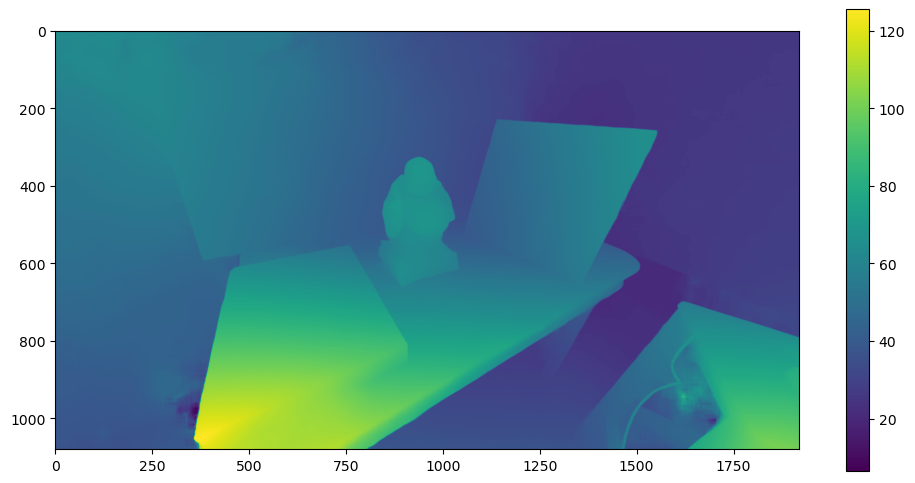

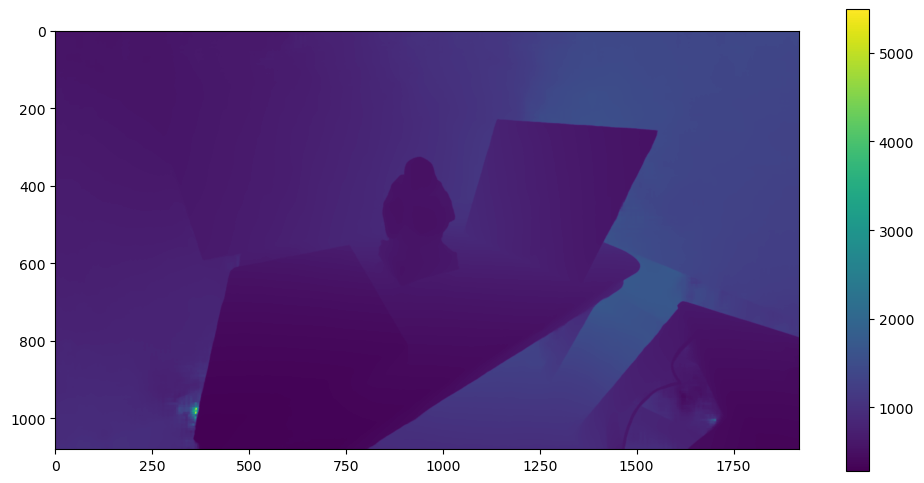

Archivo .PLY guardado como datasets/buddha_board/clouds/buddha_0.ply
models/crestereo_combined_iter5_720x1280.onnx
Archivo .PLY guardado como datasets/buddha_board/clouds/buddha_1.ply
models/crestereo_combined_iter5_720x1280.onnx
Archivo .PLY guardado como datasets/buddha_board/clouds/buddha_2.ply
models/crestereo_combined_iter5_720x1280.onnx
Archivo .PLY guardado como datasets/buddha_board/clouds/buddha_3.ply
models/crestereo_combined_iter5_720x1280.onnx
Archivo .PLY guardado como datasets/buddha_board/clouds/buddha_4.ply
models/crestereo_combined_iter5_720x1280.onnx
Archivo .PLY guardado como datasets/buddha_board/clouds/buddha_5.ply


In [9]:
left_rectified_imgs = []
right_rectified_imgs = []
disparity_maps = []
all_points = []

w, h = left_images[0].shape[1], left_images[0].shape[0]
fx = left_K[0][0]
fy = left_K[1][1]
cx0 = left_K[0][2]
cy0 = left_K[1][2]
baseline = np.linalg.norm(T)

calibration = Calibration(**{
    "width": w,
    "height": h,
    "baseline_meters": baseline / 1000,
    "fx": fx,
    "fy": fy,
    "cx0": cx0,
    "cx1": cx0,
    "cy": cy0,
    "depth_range": [0.05, 20.0],
    "left_image_rect_normalized": [0, 0, 1, 1]
})

models_path = "models"
if not os.path.exists(models_path):
    os.makedirs(models_path)

models_path = Path(models_path)
config = Config(models_path=models_path)
method = CREStereo(config)
method.parameters["Shape"].set_value("1280x720")

objp = np.zeros((checkerboard[1]*checkerboard[0], 3), np.float32)
objp[:, :2] = np.mgrid[0:checkerboard[0], 0:checkerboard[1]].T.reshape(-1, 2)
objp *= square_size_mm

pcd_global = o3d.geometry.PointCloud()

for i in range(len(left_images)):
    left_img  = left_images[i]
    right_img = right_images[i]

    # De-distorsión y rectificación
    left_rectified  = cv2.remap(left_img,  left_map_x,  left_map_y,  cv2.INTER_LINEAR)
    right_rectified = cv2.remap(right_img, right_map_x, right_map_y, cv2.INTER_LINEAR)
    left_rectified_imgs.append(left_rectified)
    right_rectified_imgs.append(right_rectified)

    # Disparidad
    pair = InputPair(left_rectified, right_rectified, calibration)
    disparity = method.compute_disparity(pair)
    disparity_maps.append(disparity)
    if i==0: # Solo para ver el primer mapa de disparidad
        plt.figure(figsize=(12, 6))
        plt.imshow(disparity.disparity_pixels)
        plt.colorbar()
        plt.show()

    # Profundidad
    disparity_map = disparity.disparity_pixels
    f = left_K[0][0]
    B = baseline
    depthh = compute_depth(disparity_map, f, B)
    depth = depthh.copy()
    depth[depth > 10000] = 10000 
    if i==0:
        plt.figure(figsize=(12, 6))
        plt.imshow(depth)
        plt.colorbar()
        plt.show()

    # Transformación de los puntos 3D
    left_found, left_corners = detect_board(checkerboard, left_rectified)
    object_3dpoints = board_points(checkerboard)
    object_3dpoints_mm = object_3dpoints * square_size_mm
    ret, rvec, tvec = cv2.solvePnP(
        object_3dpoints_mm,
        left_corners,
        left_K,
        left_dist,
        cv2.SOLVEPNP_IPPE
    )

    c_R_o = cv2.Rodrigues(rvec)
    c_T_o = np.column_stack((c_R_o[0], tvec))
    c_T_o = np.vstack((c_T_o, [0, 0, 0, 1]))
    o_T_c = np.linalg.inv(c_T_o)
    
    export_ply_grayscale(
        f"datasets/buddha_board/clouds/buddha_{i}.ply",
        depth,
        left_rectified,
        left_K[0, 0],
        left_K[0, 2],
        left_K[1, 2],
    )

    pcd = o3d.io.read_point_cloud(f"datasets/buddha_board/clouds/buddha_{i}.ply")
    pcd.transform(o_T_c)
    axis = o3d.geometry.TriangleMesh.create_coordinate_frame(size=27.0)
    origin = np.array([0, 0, 0])
    R = np.eye(3)
    extent = np.array([650.0, 700.0, 600.0])
    bbox = o3d.geometry.OrientedBoundingBox(origin, R, extent)
    pcd_cropped = pcd.crop(bbox)
    # o3d.visualization.draw_geometries([pcd_cropped, axis])
    o3d.io.write_point_cloud(f"datasets/buddha_board/cropped_clouds/buddha_{i}_crop.ply", pcd_cropped)
    pcd_global += pcd_cropped

In [10]:
# Creación del mesh global
voxel_size = 1.0
pcd_global = pcd_global.voxel_down_sample(voxel_size)
pcd_global.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(
        radius=voxel_size * 2, max_nn=30))
pcd_global.orient_normals_consistent_tangent_plane(k=30)

# Generar el mesh (Ball Pivoting, Poisson, etc.)
radii = o3d.utility.DoubleVector(np.linspace(voxel_size * 1.0,
                                             voxel_size * 3.0, 5))
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
    pcd_global, radii)

o3d.io.write_triangle_mesh("datasets/buddha_board/buddha_full_mesh.ply", mesh)
draw_geometries([mesh, axis])

# Calavera (seguir después)

In [56]:
directory = os.path.join("datasets", "skull_charuco", "captures")
left_files_pattern = "left*.jpg"
right_files_pattern = "right*.jpg"

left_images= []
right_images= []

def numeric_sort(file_name):
    return int(file_name.split("_")[-1].split(".")[0])

left_file_names = sorted(
    glob.glob(
        os.path.join(directory, left_files_pattern)
    ),
    key=numeric_sort
)

right_file_names = sorted(
    glob.glob(
        os.path.join(directory, right_files_pattern)
    ),
    key=numeric_sort
)

for left_file_name, right_file_name in zip(
    left_file_names, right_file_names
):
    # read left and right images
    left_image = cv2.imread(left_file_name, cv2.IMREAD_GRAYSCALE)
    right_image = cv2.imread(right_file_name, cv2.IMREAD_GRAYSCALE)

    # acumulo las imagenes
    left_images.append(left_image)
    right_images.append(right_image)

In [57]:
# Parámetros del tablero Charuco
use_dict = cv2.aruco.DICT_6X6_250
squares_x = 11
squares_y = 8
square_length = 87.0  # en mm
marker_length = 65.0  # en mm

board = aruco.create_charuco_board(
    squares_x,
    squares_y,
    square_length,
    marker_length,
    use_dict
)

In [58]:
stereo_calib_file = os.path.join("datasets", "skull_charuco", "stereo_calibration.pkl")
stereo_maps_file = os.path.join("datasets", "skull_charuco", "stereo_maps.pkl")

print("reading stereo calibration results...")
with open(stereo_calib_file, "rb") as f:
    calib = pickle.loads(f.read())
    
print("reading stereo rectification maps...")
with open(stereo_maps_file, "rb") as f:
    maps = pickle.loads(f.read())

K1 = calib["left_K"]
K2 = calib["right_K"]
D1 = calib["left_dist"]
D2 = calib["right_dist"]
R = calib["R"]
T = calib["T"]
E = calib["E"]
F = calib["F"]
image_size = calib["image_size"]
Q = maps["Q"]
left_map_x = maps["left_map_x"]
left_map_y = maps["left_map_y"]
right_map_x = maps["right_map_x"]
right_map_y = maps["right_map_y"]
R1 = maps["R1"]
R2 = maps["R2"]
P1 = maps["P1"]
P2 = maps["P2"]

reading stereo calibration results...
reading stereo rectification maps...


In [59]:
def compute_depth(disparity_map, f, B, default=1000.0):
    # Crea una copia del mapa de disparidad
    disparity_map = disparity_map.copy()
    # Evita divisiones por cero o disparidades negativas (les asignamos el valor default)
    mask_invalid = (disparity_map <= 0)
    # Calcula la profundidad con la fórmula Z = f * B / disparidad
    depth_map = np.zeros_like(disparity_map, dtype=np.float32)
    depth_map[~mask_invalid] = (f * B) / disparity_map[~mask_invalid]
    
    # Asigna valor fijo a los puntos donde la disparidad es inválida
    depth_map[mask_invalid] = default
    
    return depth_map

In [ ]:
def estimate_pose_cv(img, board, detection, calibration):
    K, dist_coeffs = calibration
    corners = detection['corners']
    ids = detection['ids']
    # para encontrar la pose, OpenCV recomienda usar interpolateCornersCharuco
    # para estimar donde están los corners del tablero
    # luego busca con precisión de sub-píxel los corners y devuelve los resultados mejorados
    interpolation = cv2.aruco.interpolateCornersCharuco(
        markerCorners=corners,
        markerIds=ids,
        image=img,
        board=board
    )
    # el resultado es la cantidad de corners que pudo interpolar
    # las posiciones de los corners interpolados y los ids correspondientes.
    num, ch_corners, ch_ids = interpolation
    if num < 4:
        print ("no se pudo interpolar la pose.")
        return False, None, None
    # la librería devuelve la pose usando la función estimatePoseCharucoBoard
    pose = cv2.aruco.estimatePoseCharucoBoard(
        ch_corners,
        ch_ids,
        board,
        K,   
        dist_coeffs, 
        np.empty(1), 
        np.empty(1) 
    )
    ok, rv, tv = pose

    return pose

models/crestereo_combined_iter5_720x1280.onnx


/Users/mateolopezv/miniconda3/lib/python3.12/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:118: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CoreMLExecutionProvider, AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


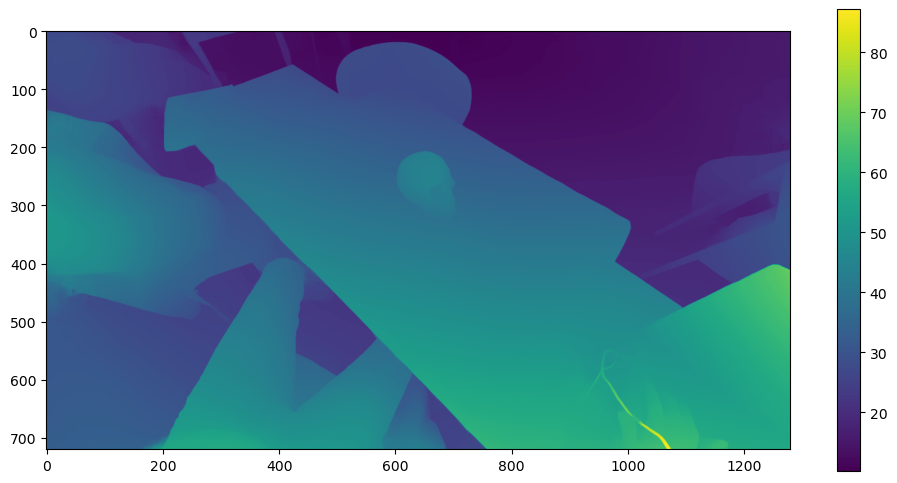

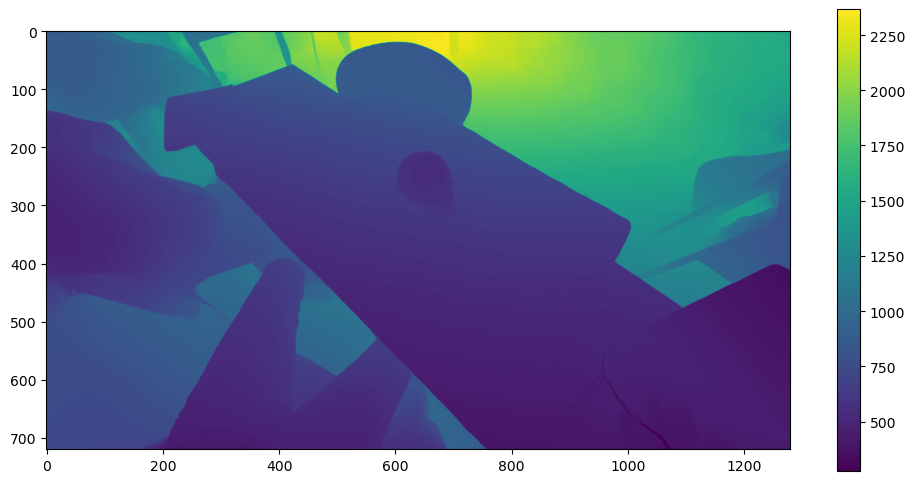

TypeError: 'NoneType' object is not subscriptable

In [61]:
left_rectified_imgs = []
right_rectified_imgs = []
disparity_maps = []
all_points = []

w, h = left_images[0].shape[1], left_images[0].shape[0]
fx = K1[0][0]
fy = K1[1][1]
cx0 = K1[0][2]
cy0 = K1[1][2]
baseline = np.linalg.norm(T)

calibration = Calibration(**{
    "width": w,
    "height": h,
    "baseline_meters": baseline / 1000,
    "fx": fx,
    "fy": fy,
    "cx0": cx0,
    "cx1": cx0,
    "cy": cy0,
    "depth_range": [0.05, 20.0],
    "left_image_rect_normalized": [0, 0, 1, 1]
})

models_path = "models"
if not os.path.exists(models_path):
    os.makedirs(models_path)

models_path = Path(models_path)
config = Config(models_path=models_path)
method = CREStereo(config)
method.parameters["Shape"].set_value("1280x720")

pcd_global = o3d.geometry.PointCloud()

for i in range(len(left_images)):
    left_img  = left_images[i]
    right_img = right_images[i]

    # De-distorsión y rectificación
    left_rectified  = cv2.remap(left_img,  left_map_x,  left_map_y,  cv2.INTER_LINEAR)
    right_rectified = cv2.remap(right_img, right_map_x, right_map_y, cv2.INTER_LINEAR)
    left_rectified_imgs.append(left_rectified)
    right_rectified_imgs.append(right_rectified)

    # Disparidad
    pair = InputPair(left_rectified, right_rectified, calibration)
    disparity = method.compute_disparity(pair)
    disparity_maps.append(disparity)
    if i==0: # Solo para ver el primer mapa de disparidad
        plt.figure(figsize=(12, 6))
        plt.imshow(disparity.disparity_pixels)
        plt.colorbar()
        plt.show()

    # Profundidad
    disparity_map = disparity.disparity_pixels
    f = K1[0][0]
    B = baseline
    depthh = compute_depth(disparity_map, f, B)
    depth = depthh.copy()
    depth[depth > 10000] = 10000 
    if i==0:
        plt.figure(figsize=(12, 6))
        plt.imshow(depth)
        plt.colorbar()
        plt.show()

    # Transformación de los puntos 3D
    calibration = K1, D1
    detection = aruco.detect_charuco_markers(left_rectified, board)
    pose = estimate_pose_cv(left_rectified, board, detection, calibration)
    ok, rvec, tvec = pose

    c_R_o = cv2.Rodrigues(rvec)
    c_T_o = np.column_stack((c_R_o[0], tvec))
    c_T_o = np.vstack((c_T_o, [0, 0, 0, 1]))
    o_T_c = np.linalg.inv(c_T_o)
    
    export_ply_grayscale(
        f"datasets/skull_charuco/clouds/skull_{i}.ply",
        depth,
        left_rectified,
        K1[0, 0],
        K1[0, 2],
        K1[1, 2],
    )

    pcd = o3d.io.read_point_cloud(f"datasets/clouds/skull_{i}.ply")
    pcd.transform(o_T_c)
    axis = o3d.geometry.TriangleMesh.create_coordinate_frame(size=27.0)
    origin = np.array([0, 0, 0])
    R = np.eye(3)
    extent = np.array([650.0, 700.0, 600.0])
    bbox = o3d.geometry.OrientedBoundingBox(origin, R, extent)
    pcd_cropped = pcd.crop(bbox)
    # o3d.visualization.draw_geometries([pcd_cropped, axis])
    o3d.io.write_point_cloud(f"datasets/skull_charuco/cropped_clouds/skull_{i}_crop.ply", pcd_cropped)
    pcd_global += pcd_cropped